### Fig 3.5 tesis Loewen

### $\sigma_z$, $z_{50}$, metalicidad y SFR vs age

In [1]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import z50 as z50_prof
import velocity_dispersion as vd
import z50

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for i in range(1):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[i])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[i]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Rvir = snap['/R200'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    met  = snap['/Str/Total_Metallicity'][()]
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    Ztot = met[amask]/0.0127 #para pasarlo a metalicidad solar (ver Illustris data)

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]
    
    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    Rn_str = np.sqrt(xn_str**2 + yn_str**2)

    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
        
    gal, = np.where((Rn_str < r50+1) & (Rn_str > r50-1) & 
                    (zn_str < 5) & (zn_str > -5))
    
    w0, = np.where(Ztot[gal]>0)
    
    edad  = age[gal][w0]
    x_str = xn_str[gal][w0]
    y_str = yn_str[gal][w0]
    z_str = zn_str[gal][w0]
    Z_tot = Ztot[gal][w0]
    m_str = mstr[gal][w0]
    
    age_bin = np.linspace(0,14,20)
       
    sigma_z = np.zeros(len(age_bin)-1)*np.nan
    edades  = np.zeros(len(age_bin)-1)*np.nan
    met     = np.zeros(len(age_bin)-1)*np.nan
    z_50    = np.zeros(len(age_bin)-1)*np.nan
    SFR     = np.zeros(len(age_bin)-1)*np.nan
    SigSFR  = np.zeros(len(age_bin)-1)*np.nan
    
    area = np.pi*2*r50
    
    for j in range(len(age_bin)-1):
        age_lim, = np.where((edad>age_bin[j]) & (edad<age_bin[j+1]))
        
        if len(age_lim)<2:
            continue
        
        edades[j] = np.median(edad[age_lim])
        sigma_z[j] = vd.vel_disp(vzn[gal][w0][age_lim])
        z_50[j] = z50.z50v(z_str[age_lim],m_str[age_lim])
        met[j] = np.median(Z_tot[age_lim])
        
        dt = age_bin[j+1]-age_bin[j]
        Mtot = np.sum(m_str[age_lim])
        SFR[j]  = Mtot/(dt*1e9)
        SigSFR[j] = SFR[j]/area
        
    
    data = np.ndarray([len(age_bin)-1,6])
    data[:,0] = edades
    data[:,1] = sigma_z
    data[:,2] = z_50
    data[:,3] = met
    data[:,4] = SFR
    data[:,5] = SigSFR
    
    np.savetxt('../_data/Fig3.5/fig3.5_sh'+Id+'.dat', data, fmt=('%12.8f','%12.8f','%12.8f','%12.8f','%12.8f','%12.8f'))

subhalo_127000000000002


### Guardo los datos para el SFgas en distintos tiempos


In [55]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as timeconv
import z50 as z50_prof
import velocity_dispersion as vd
import z50

ID = np.loadtxt('../_data/my_halos.dat')[:,0]
snapshot = np.loadtxt('../_data/time.dat')[:,0]
time = np.loadtxt('../_data/time.dat')[:,3]

path = '/store/erebos/omarioni/_simulations/snap_'

for i in range(3,14):
    
    print('subhalo_'+str('%d'%ID[i]))
    
    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
    
    file = open('../_data/Fig3.5/fig3.5_snap_sh'+Id+'.dat','a')
    
    for j in range(len(snapshot)):
        
        snap = h5py.File(path + str('%03d'%snapshot[j]) +'/subhalo_'+str('%d'%ID[i])+'.h5py', 'r')

        aexp = snap['/Time'][()]
        h    = snap['/h'][()]
        Rvir = snap['/R200'][()]
        Om_L = snap['/Omega_Lambda'][()]
        Om_M = snap['/Omega_0'][()]

        pstr = snap['/Str/Coordinates'][()]
        mstr = snap['/Str/Masses'][()]
        vstr = snap['/Str/Velocities'][()]

        pgas   = snap['/Gas/Coordinates'][()]
        mgas   = snap['/Gas/Masses'][()]
        vgas   = snap['/Gas/Velocities'][()]
        sfrgas = snap['/Gas/StarFormationRate'][()]
        metgas = snap['/Gas/Total_Metallicity'][()]
        
        metstr = snap['/Str/Total_Metallicity'][()]
        sft    = snap['/Str/FormationTime'][()]

        amask, = np.where(sft>0)#aca puede haber particulas con age<0, esas no son estrellas son gas cells.b
        if len(amask)<2:
            continue
        ages = timeconv.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
        age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

        Ztot_str = metstr[amask]/0.0127 #para pasarlo a metalicidad solar (ver Illustris data)
        
        sfgas = np.where(sfrgas>0)

        xstr = pstr[amask,0]*aexp/h
        ystr = pstr[amask,1]*aexp/h
        zstr = pstr[amask,2]*aexp/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        Ztot_gas = metgas[sfgas]/0.0127
        
        xgas = pgas[sfgas,0]*aexp/h
        ygas = pgas[sfgas,1]*aexp/h
        zgas = pgas[sfgas,2]*aexp/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

        v_x = vstr[amask,0] *np.sqrt(aexp)
        v_y = vstr[amask,1] *np.sqrt(aexp)
        v_z = vstr[amask,2] *np.sqrt(aexp)
        
        vx_gas = vgas[sfgas,0] *np.sqrt(aexp)
        vy_gas = vgas[sfgas,1] *np.sqrt(aexp)
        vz_gas = vgas[sfgas,2] *np.sqrt(aexp)

        #----------------------masas----------------------------
        mstr = mstr[amask]*1e10/h
        mgas = mgas[sfgas]*1e10/h

        rgal = 0.15*Rvir*aexp/h

        limit, = np.where(rstr < rgal)
        
        if len(limit)<2:
            continue
        
        rsort = np.argsort(rstr[limit])
        Mc = np.cumsum(mstr[limit][rsort])
        Mgal = Mc[-1]
        limit50, = np.where(Mc < Mgal/2)
        
        if len(limit50)<2:
            continue

        r50 = rstr[limit][rsort][limit50][-1]
        
        if snapshot[j] ==127:
            r50_z0 = r50

        veloc,=np.where(rstr < r50/2.)
        
        if len(veloc)<2:
            continue

        #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm
        
        vxgas = vx_gas - vxcm
        vygas = vy_gas - vycm
        vzgas = vz_gas - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

        xn_str = e1x*xstr + e1y*ystr + e1z*zstr
        yn_str = e2x*xstr + e2y*ystr + e2z*zstr
        zn_str = e3x*xstr + e3y*ystr + e3z*zstr
        vxn_str = e1x*vx + e1y*vy + e1z*vz
        vyn_str = e2x*vx + e2y*vy + e2z*vz
        vzn_str = e3x*vx + e3y*vy + e3z*vz
        
        xn_gas = e1x*xgas + e1y*ygas + e1z*zgas
        yn_gas = e2x*xgas + e2y*ygas + e2z*zgas
        zn_gas = e3x*xgas + e3y*ygas + e3z*zgas
        vxn_gas = e1x*vxgas + e1y*vygas + e1z*vzgas
        vyn_gas = e2x*vxgas + e2y*vygas + e2z*vzgas
        vzn_gas = e3x*vxgas + e3y*vygas + e3z*vzgas

        Rn_str = np.sqrt(xn_str**2 + yn_str**2)
        Rn_gas = np.sqrt(xn_gas**2 + yn_gas**2)

        gal_str, = np.where(
            (Rn_str < r50_z0+1) & (Rn_str > r50_z0-1) &
            (zn_str < 5) & (zn_str > -5)
        )
        
        gal_gas = np.where(
            (Rn_gas < r50_z0+1) & (Rn_gas > r50_z0-1) & 
            (zn_gas < 5) & (zn_gas > -5)
        )
        
        area = np.pi*2*r50_z0
        
        w0_str, = np.where(Ztot_str[gal_str]>0)

        edad  = age[gal_str][w0_str]
        x_str = xn_str[gal_str][w0_str]
        y_str = yn_str[gal_str][w0_str]
        z_str = zn_str[gal_str][w0_str]
        Ztstr = Ztot_str[gal_str][w0_str]
        m_str = mstr[gal_str][w0_str]
        
        age_lim, = np.where(edad < 0.1)
        
        if len(age_lim)>2:
            sigma_z_str = vd.vel_disp(vzn_str[gal_str][w0_str][age_lim])
            z_50_str = z50.z50v(z_str[age_lim],m_str[age_lim])
            met_str = np.median(Ztstr[age_lim])

            dt = 0.1
            Mtot = np.sum(m_str[age_lim])
            SFR_str  = Mtot/(dt*1e9)
            SigSFR_str = SFR_str/area
        
        else:
            sigma_z_str = np.nan
            z_50_str = np.nan
            met_str = np.nan
            SFR_str = np.nan
            SigSFR_str = np.nan
        
        w0_gas, = np.where(Ztot_gas[gal_gas[0]]>0)
        
        if len(w0_gas)>2:
        
            x_gas = xn_gas[gal_gas][w0_gas]
            y_gas = yn_gas[gal_gas][w0_gas]
            z_gas = zn_gas[gal_gas][w0_gas]
            Ztgas = Ztot_gas[gal_gas[0]][w0_gas]
            m_gas = mgas[gal_gas[0]][w0_gas]

            sigma_z_gas = vd.vel_disp(vzn_gas[gal_gas][w0_gas])
            z_50_gas = z50.z50v(z_gas,m_gas)
            met_gas = np.median(Ztgas)
            SFR_gas = np.sum(sfrgas[sfgas][gal_gas[0]][w0_gas])
            SigSFR_gas = np.sum(sfrgas[sfgas][gal_gas[0]][w0_gas]*m_gas)/area
        
        else:
            sigma_z_gas = np.nan
            z_50_gas = np.nan
            met_gas = np.nan
            SFR_gas = np.nan
            SigSFR_gas = np.nan
        
        lookbacktime = np.max(time)-time[j]
        
        data = np.ndarray([1,11])
        data[:,0] = lookbacktime
        data[:,1] = sigma_z_str
        data[:,2] = z_50_str
        data[:,3] = met_str
        data[:,4] = SFR_str
        data[:,5] = SigSFR_str
        data[:,6] = sigma_z_gas
        data[:,7] = z_50_gas
        data[:,8] = met_gas
        data[:,9] = SFR_gas
        data[:,10] = SigSFR_gas

        np.savetxt(file, data, 
                   fmt=('%12.8f','%12.8f','%12.8f','%12.8f','%12.8f',
                        '%12.8f','%12.8f','%12.8f','%12.8f','%12.8f','%12.8f'))
    
    file.close()

subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023
subhalo_127000000000028
subhalo_127000000000031


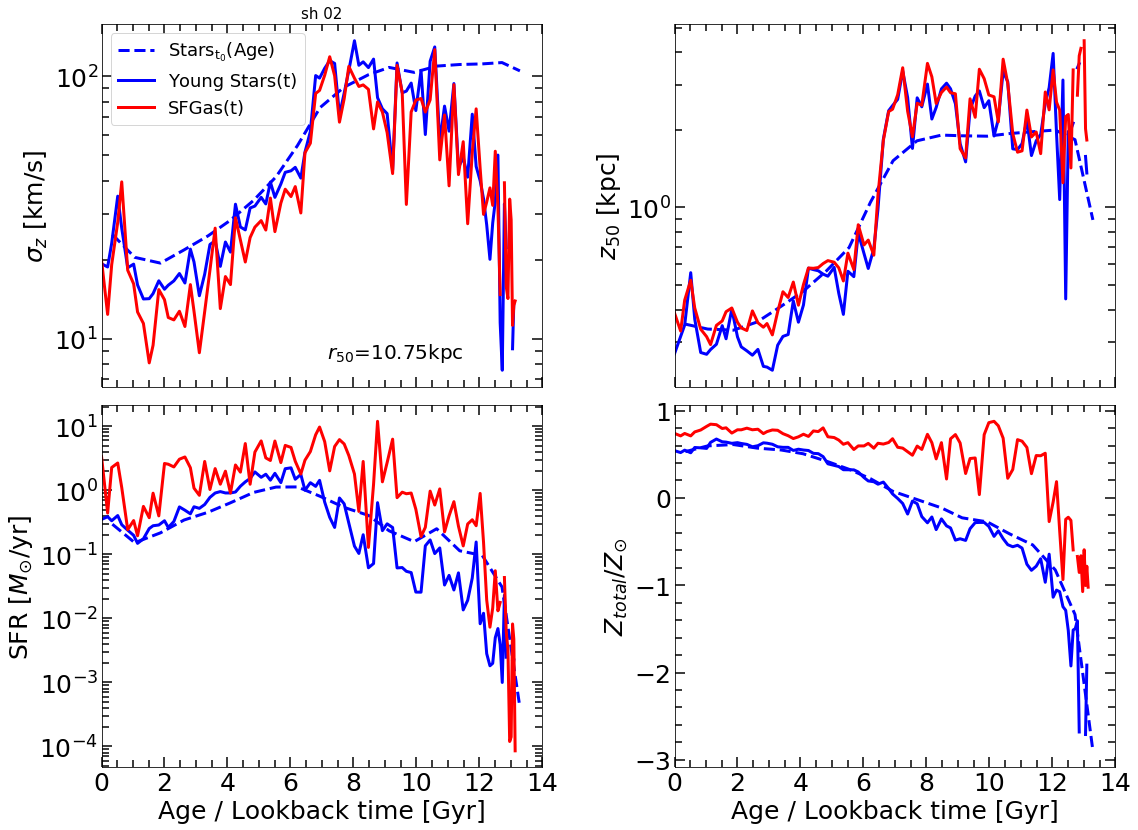

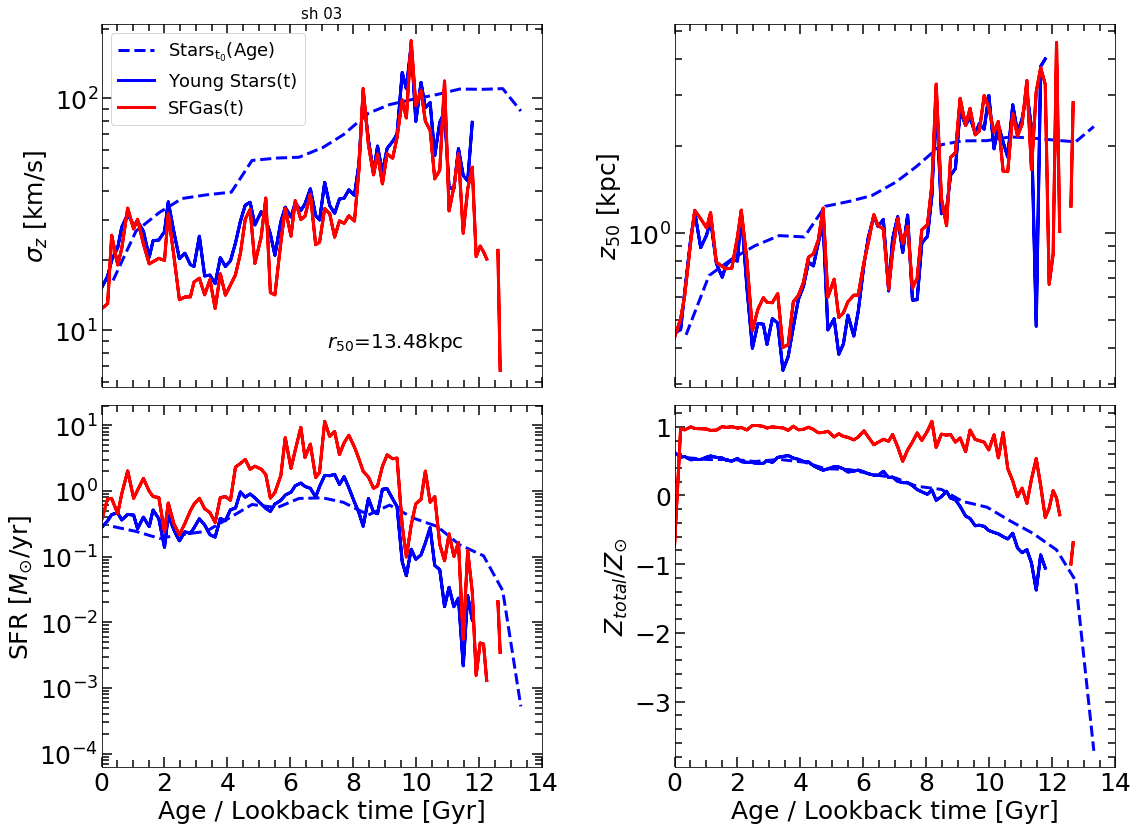

/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


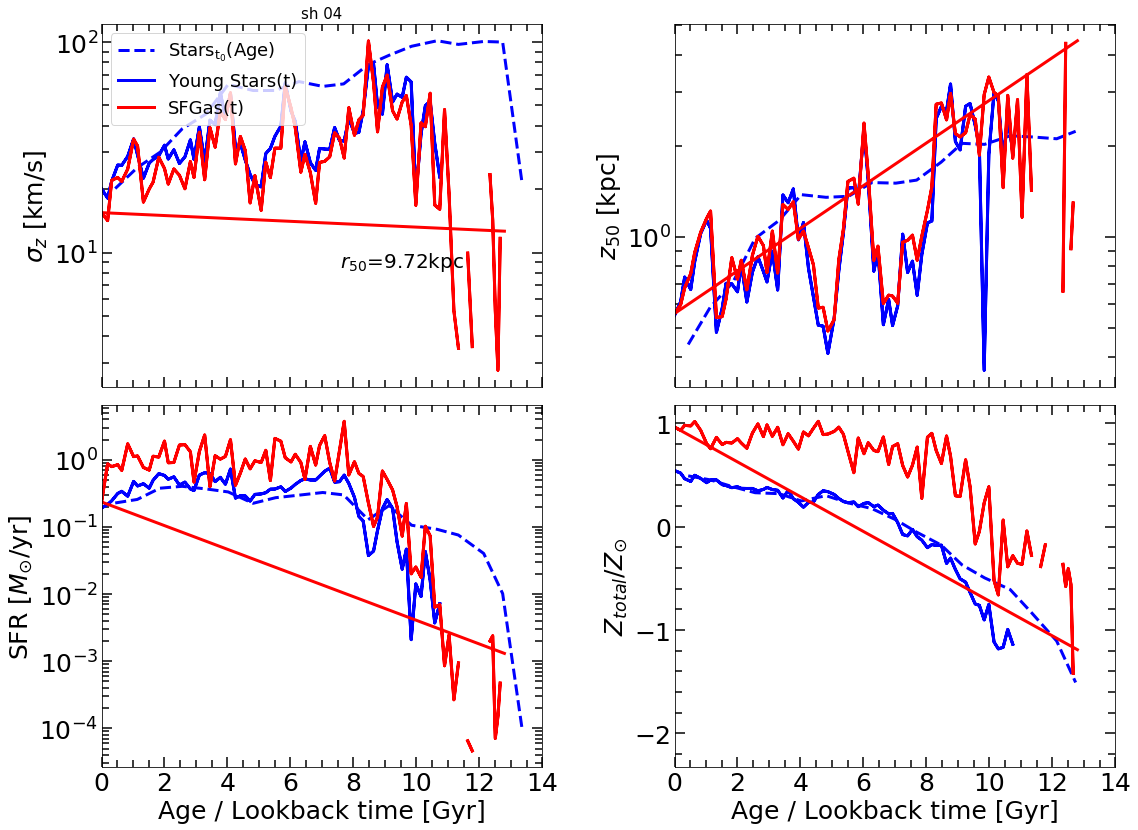

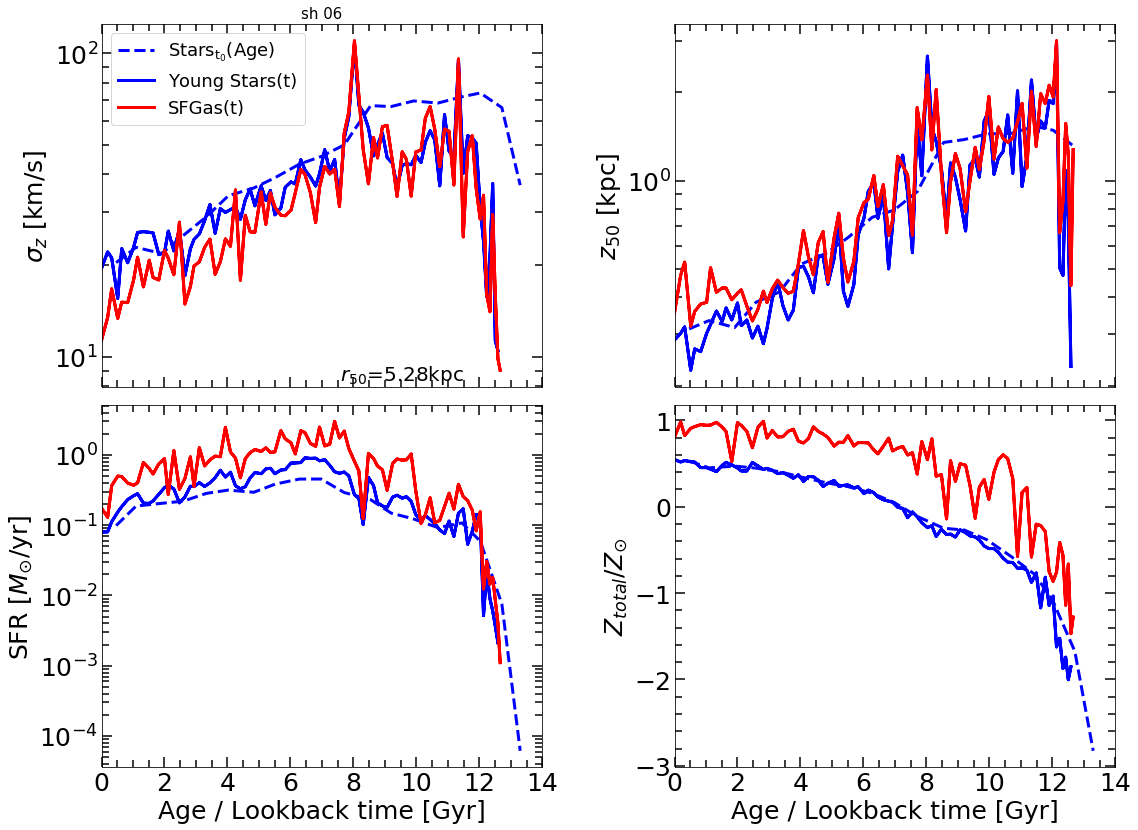

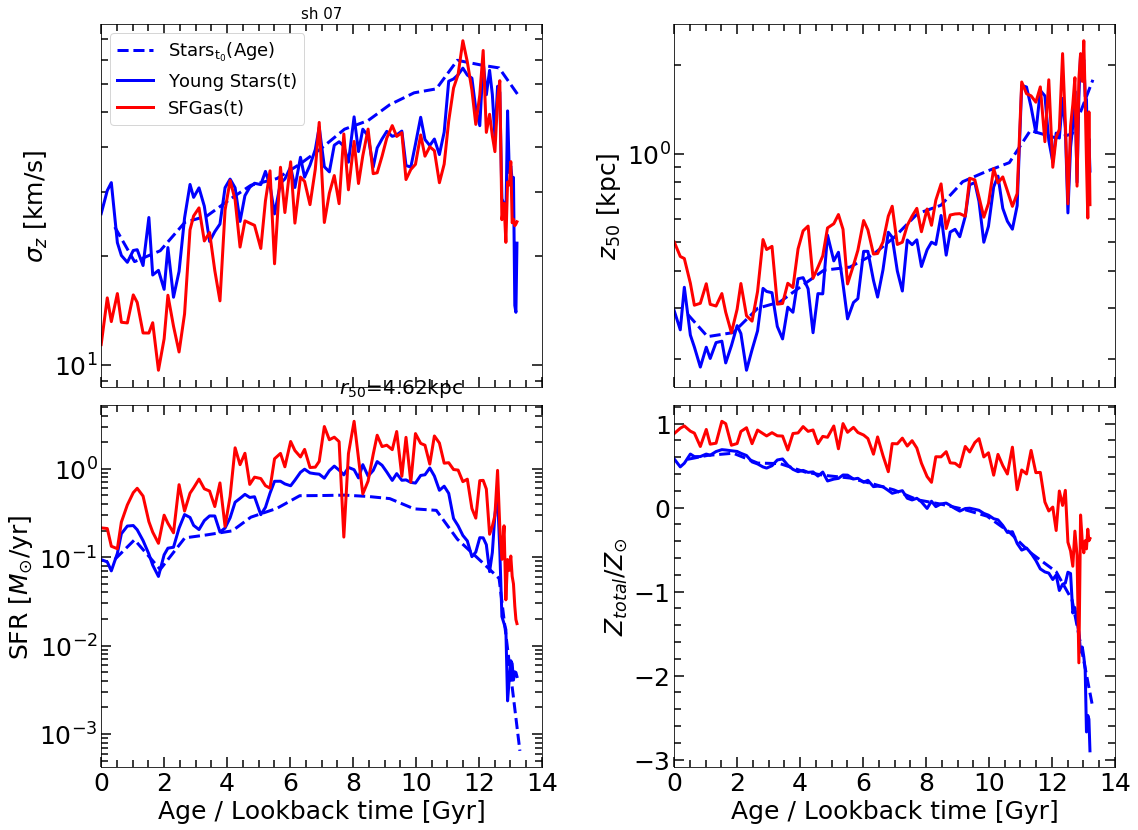

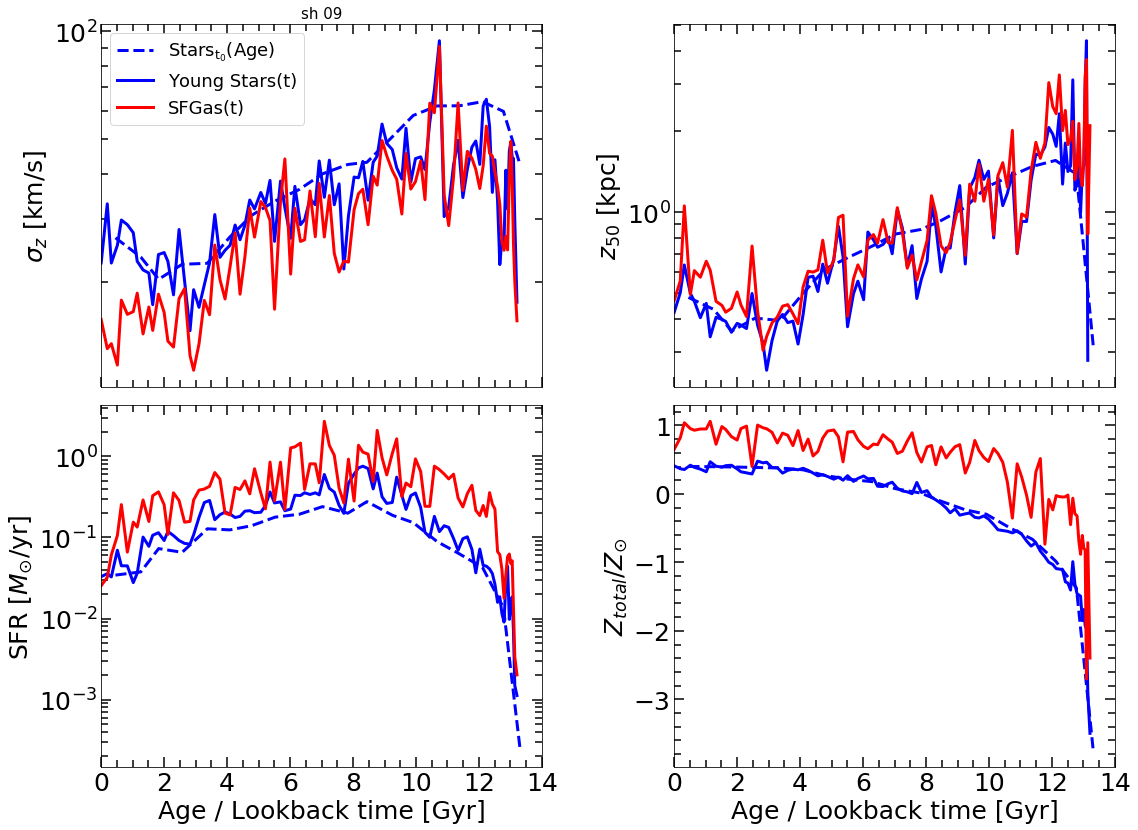

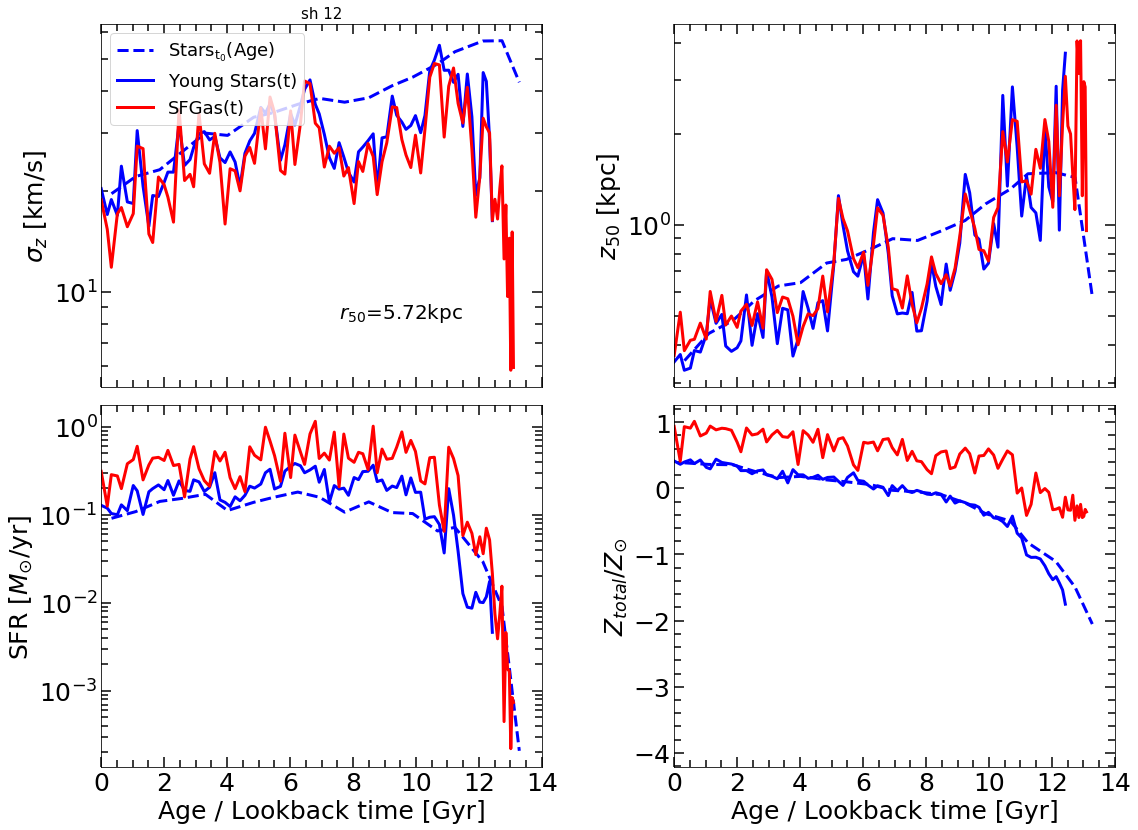

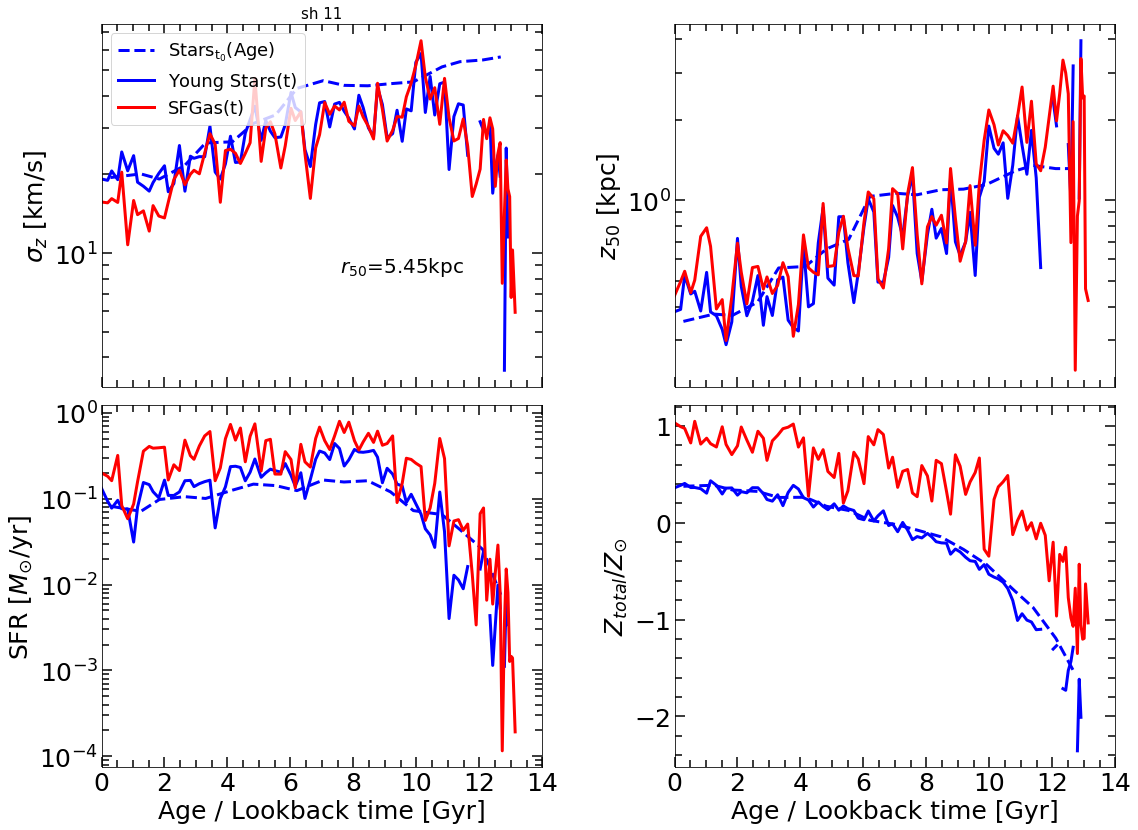

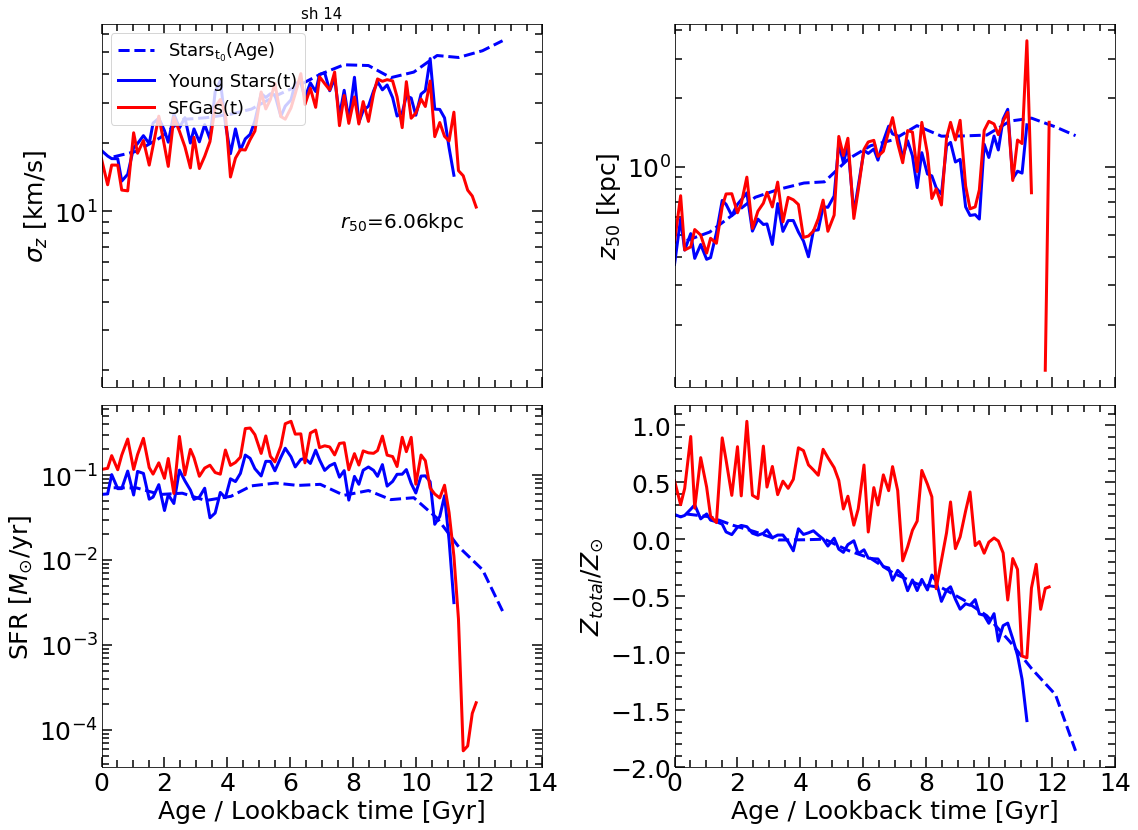

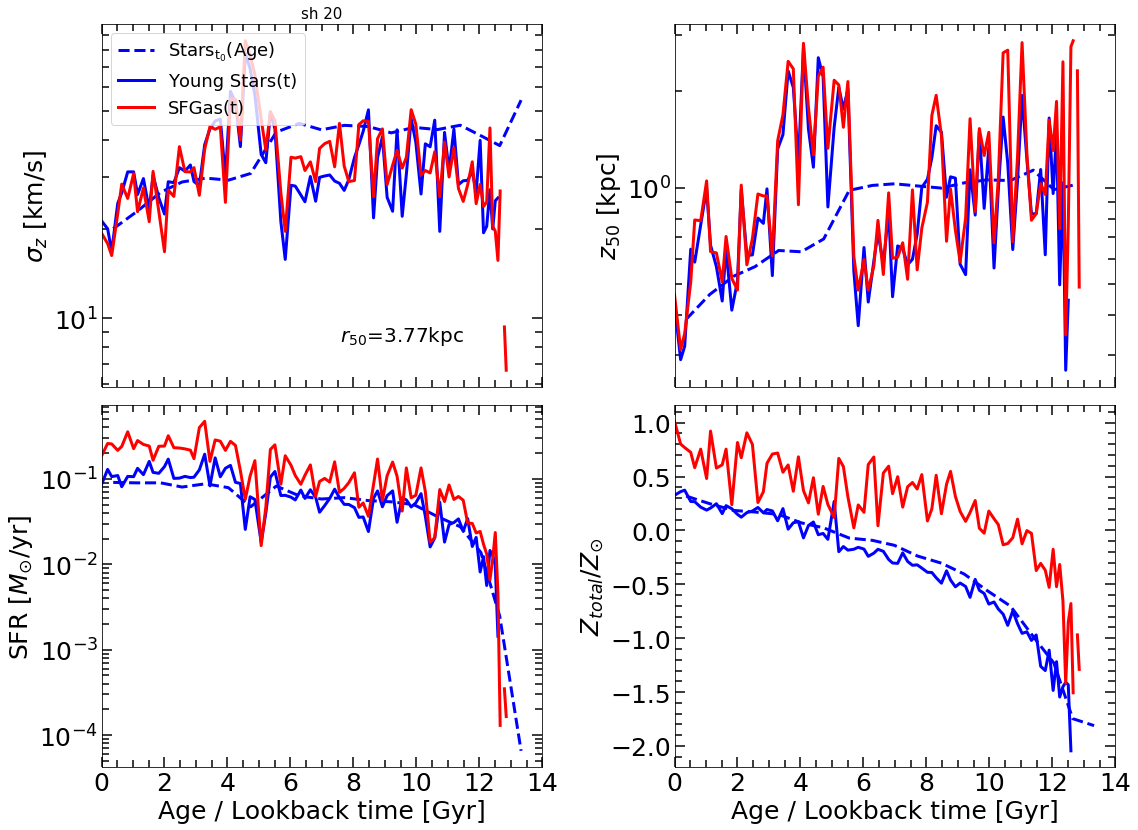

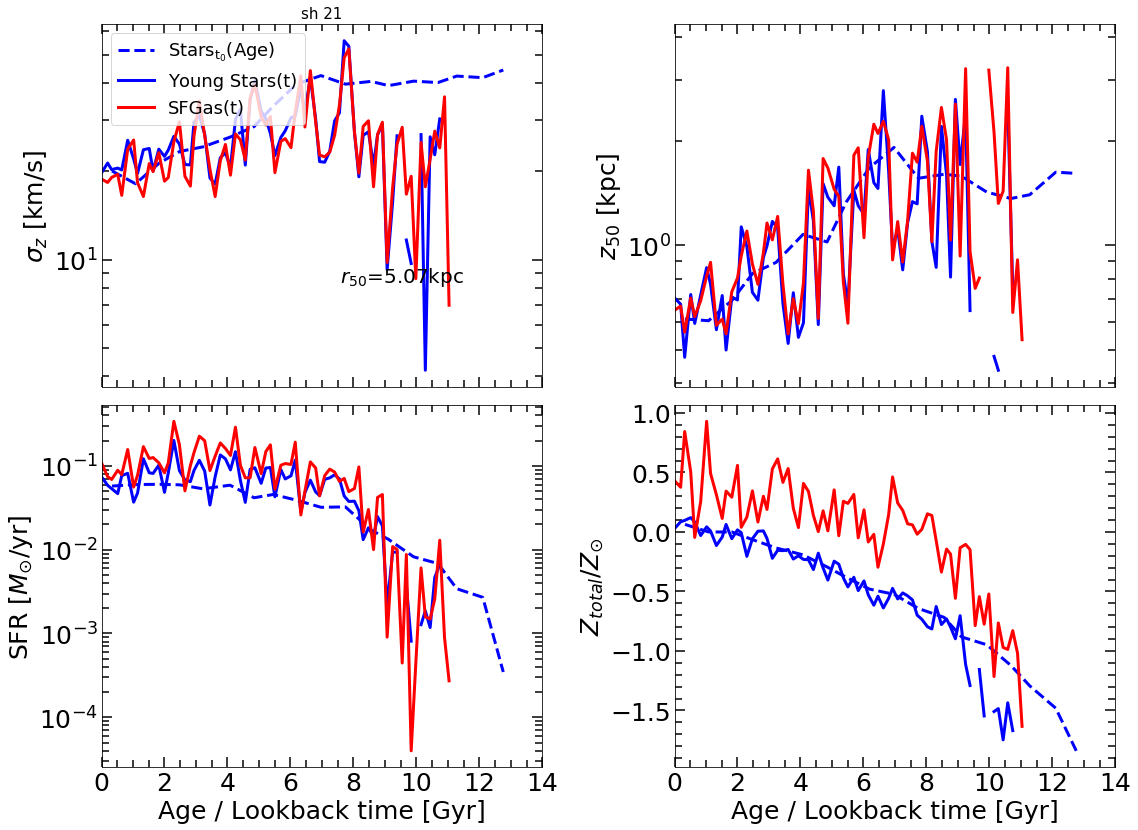

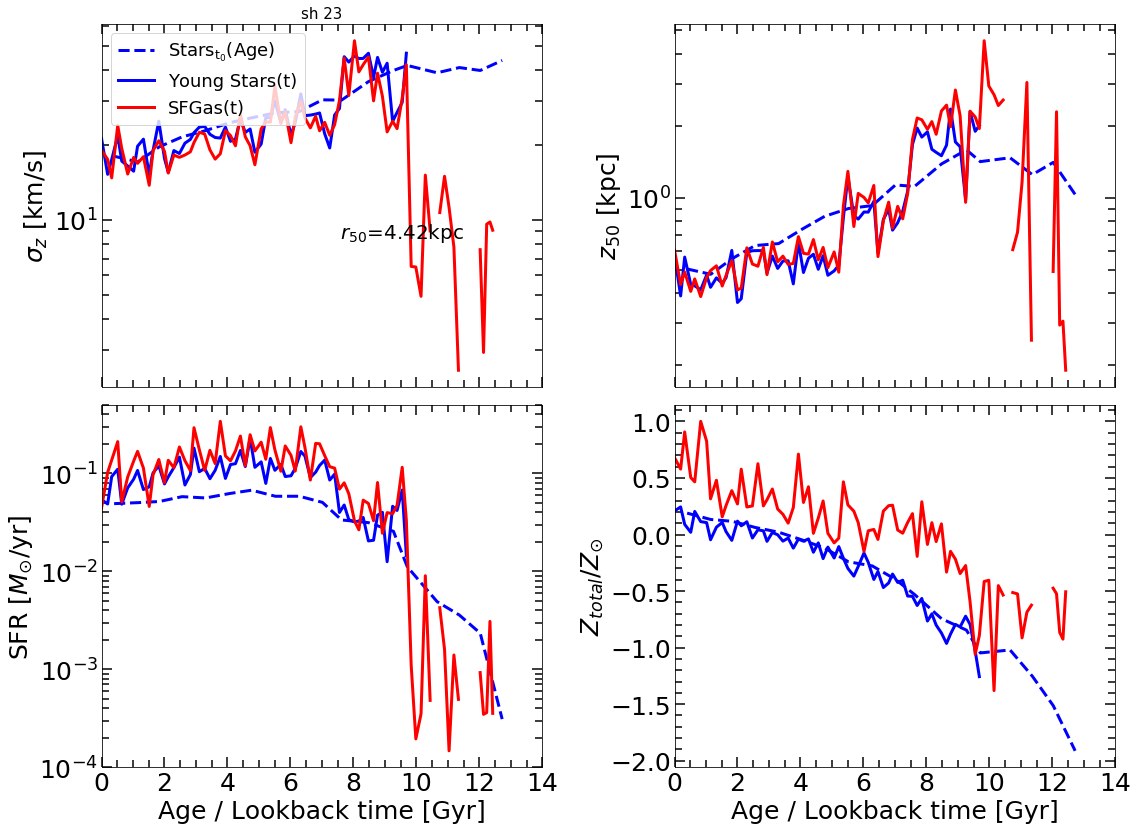

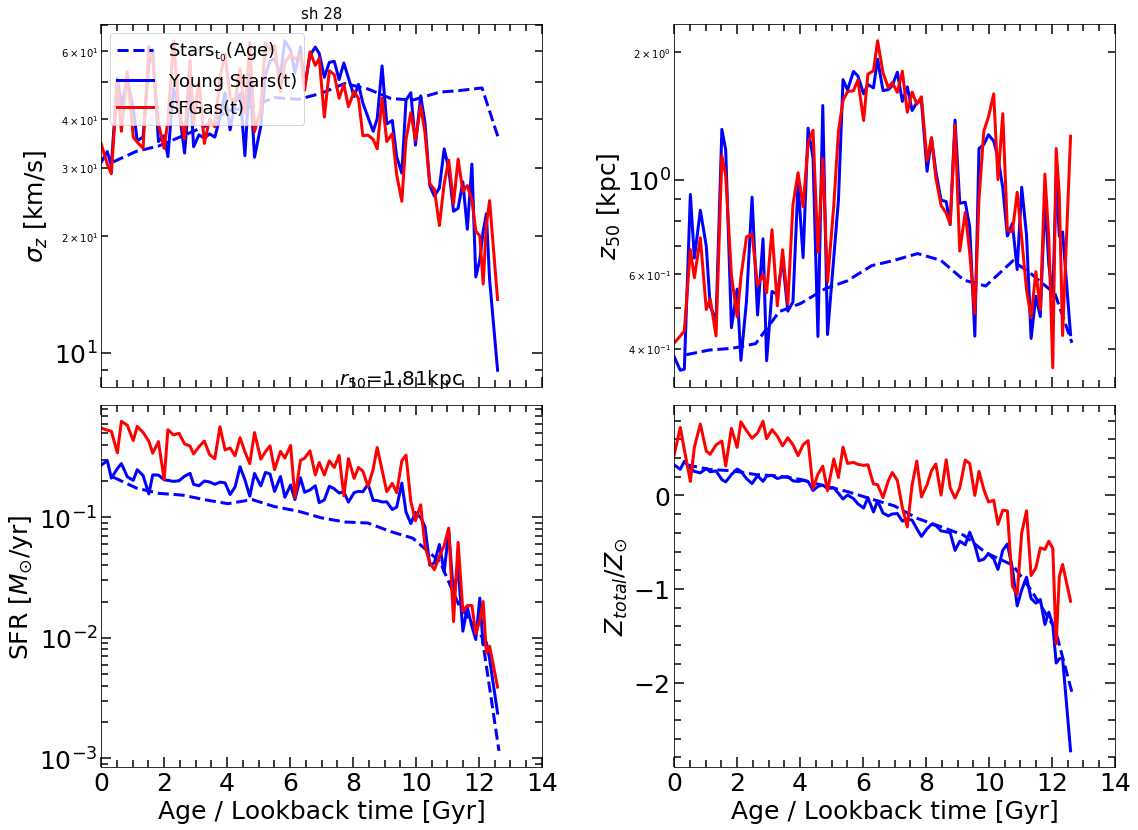

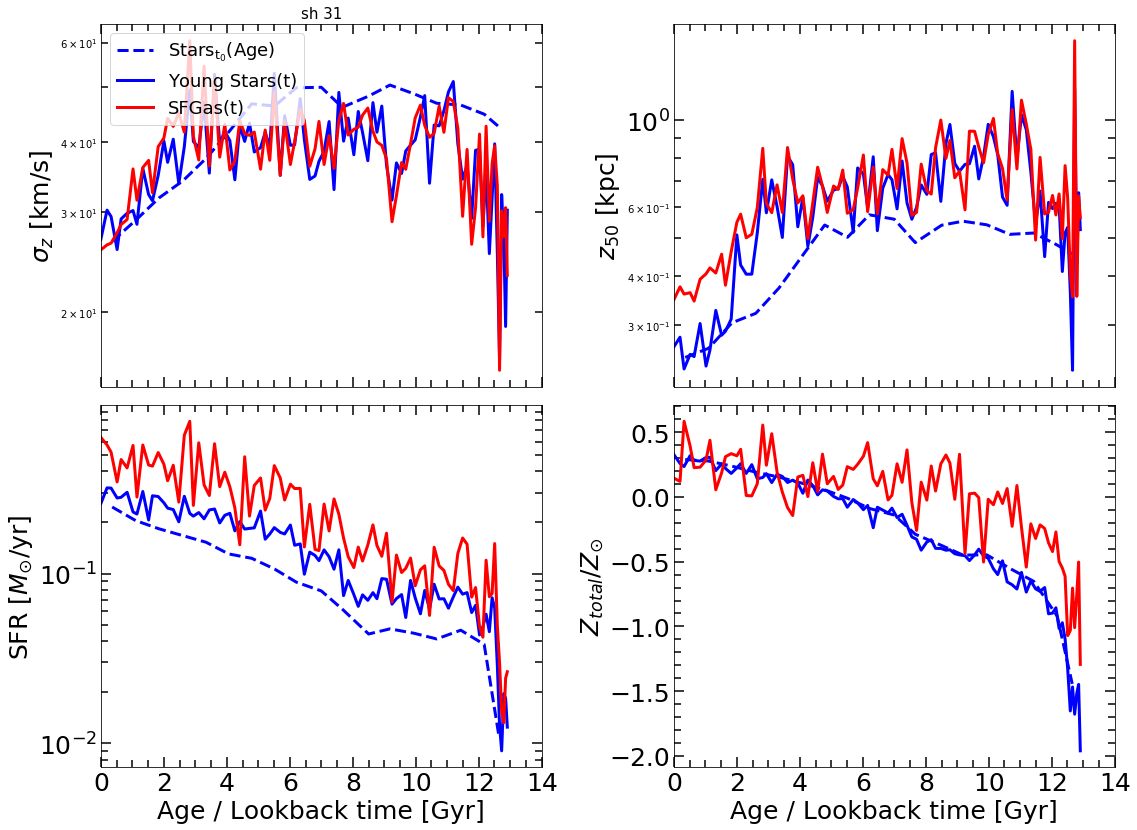

In [56]:
import numpy as np

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

r50 = np.loadtxt('../_data/r50.dat')[:,1]

for i in range(14): 
    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
        
    data = np.loadtxt('../_data/Fig3.5/fig3.5_sh'+Id+'.dat')
    
    edad    = data[:,0]
    sigma_z = data[:,1]
    z_50    = data[:,2]        
    met     = data[:,3]        
    SFR     = data[:,4]
    
    data2 = np.loadtxt('../_data/Fig3.5/fig3.5_snap_sh'+Id+'.dat')
    
    tiempo      = data2[:,0]
    sigma_z_str = data2[:,1]
    z_50_str    = data2[:,2]        
    met_str     = data2[:,3]        
    SFR_str     = data2[:,4]
    sigma_z_gas = data2[:,6]
    z_50_gas    = data2[:,7]        
    met_gas     = data2[:,8]        
    SFR_gas     = data2[:,9]
    
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    fig.subplots_adjust(bottom=0.10, left =0.10, right = 0.98,top=0.96, hspace=0.05, wspace=0.3)

    ax[0,0].plot(edad,sigma_z,'b--',lw=3, label='$\mathrm{Stars_{t_{0}}}$(Age)')
    ax[0,0].plot(tiempo,sigma_z_str,'b-',lw=3, label='Young Stars(t)')
    ax[0,0].plot(tiempo,sigma_z_gas,'r-',lw=3, label='SFGas(t)')
    ax[0,0].set_yscale('log')
    ax[0,0].set_xlim(0,14)
    ax[0,0].set_xticks([0,2,4,6,8,10,12,14])
    ax[0,0].set_xticklabels([])
    ax[0,0].minorticks_on()
    ax[0,0].tick_params(labelsize=25)
    ax[0,0].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[0,0].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[0,0].set_ylabel('$\sigma_z$ [km/s]',fontsize=25)
    ax[0,0].set_title('sh '+Id, fontsize=15)
    ax[0,0].text(11.5,8,'$r_{50}$='+str('%2.2f'%r50[i])+'kpc', 
                 fontsize=20, ha='right',va='bottom')
    ax[0,0].legend(fontsize=18,fancybox=True, loc=2)
    
    ax[0,1].plot(edad,z_50,'b--',lw=3)
    ax[0,1].plot(tiempo,z_50_str,'b-',lw=3)
    ax[0,1].plot(tiempo,z_50_gas,'r-',lw=3)
    ax[0,1].set_xlim(0,14)
    ax[0,1].set_xticks([0,2,4,6,8,10,12,14])
    ax[0,1].set_xticklabels([])
    ax[0,1].set_yscale('log')
    ax[0,1].minorticks_on()
    ax[0,1].tick_params(labelsize=25)
    ax[0,1].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[0,1].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[0,1].set_ylabel('$z_{50}$ [kpc]',fontsize=25)
    
    ax[1,0].plot(edad,SFR,'b--',lw=3)
    ax[1,0].plot(tiempo,SFR_str,'b-',lw=3)
    ax[1,0].plot(tiempo,SFR_gas,'r-',lw=3)
    ax[1,0].set_yscale('log')
    ax[1,0].set_xlim(0,14)
    ax[1,0].set_xticks([0,2,4,6,8,10,12,14])
    ax[1,0].minorticks_on()
    ax[1,0].tick_params(labelsize=25)
    ax[1,0].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[1,0].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[1,0].set_ylabel('SFR [$M_{\odot}$/yr]',fontsize=25)
    ax[1,0].set_xlabel('Age / Lookback time [Gyr]',fontsize=25)
    
    ax[1,1].plot(edad,np.log10(met),'b--',lw=3)
    ax[1,1].plot(tiempo,np.log10(met_str),'b-',lw=3)
    ax[1,1].plot(tiempo,np.log10(met_gas),'r-',lw=3)
    ax[1,1].set_xlim(0,14)
    ax[1,1].set_xticks([0,2,4,6,8,10,12,14])
    ax[1,1].minorticks_on()
    ax[1,1].tick_params(labelsize=25)
    ax[1,1].tick_params('both', length=7, width=1.5,which='minor', direction='in', right=True,top=True)
    ax[1,1].tick_params('both', length=10, width=1.5,which='major', direction='in', right=True,top=True)
    ax[1,1].set_ylabel('$Z_{total}$/$Z_{\odot}$',fontsize=25)
    ax[1,1].set_xlabel('Age / Lookback time [Gyr]',fontsize=25)
    

    plt.show()
    
    fig.savefig('../_imagenes/Fig3.5/Fig3.5_sh'+Id+'.png',dpi=100, xxbox_inches='tight')    

In [22]:
print(len(sigma_z_str))

18145


### Guardo $r_{50}$ para las galaxias

In [ ]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import z50 as z50_prof
import velocity_dispersion as vd
import z50

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

file = open('../_data/r50.dat','a')

for i in range(14):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[i])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[i]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Rvir = snap['/R200'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]

    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]
    
    file.write(
        str('%d'%ID[i])   + '\t' +
        str('%12.8f'%r50) + '\n'
    )
    
file.close()

subhalo_127000000000002
subhalo_127000000000003
subhalo_127000000000004
subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023
subhalo_127000000000028
subhalo_127000000000031
